# Librerias a utilizar

In [2]:
# librerias para manipulacion de archivos
import os
import glob
import shutil

# Libreria para crear archivo YAML
import yaml

# librerias para manipulacion de imagenes
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# librerias para aumentar datos
import albumentations as A

# Librerias para utilidades
import random
from collections import Counter


# Creacion del dataset
---

Este código crea un dataset estructurado para YOLO a partir de imágenes y anotaciones existentes. Define rutas para los datos y la configuración del dataset, incluyendo la lista de clases y el número de clases. 

Luego, crea las carpetas necesarias para almacenar las imágenes y anotaciones divididas en conjuntos de entrenamiento y validación. Guarda la configuración en un archivo YAML y los nombres de las clases en un archivo de texto. 

Recoge todos los archivos de anotaciones y los divide en conjuntos de entrenamiento y validación, moviendo las anotaciones correspondientes a las carpetas respectivas. Finalmente, mueve las imágenes correspondientes a cada conjunto de anotaciones a sus carpetas designadas. 

In [3]:
# Ruta a las imágenes y anotaciones
DATA_PATH = "fotos_textos_data"
DST_DATASET = "data_yolo"

# Configuración del dataset YOLO
yolo_ds_config = {
    "train": "./images/train/",
    "val": "./images/val/",
    "nc": 51,
    "names": [
        "1O", "1C", "1E", "1B", "2O", "2C", "2E", "2B", "3O", "3C", "3E", "3B", "4O", "4C", "4E", "4B", "5O", "5C", "5E", "5B",
        "6O", "6C", "6E", "6B", "7O", "7C", "7E", "7B", "8O", "8C", "8E", "8B", "9O", "9C", "9E", "9B", "10O", "10C", "10E", "10B",
        "11O", "11C", "11E", "11B", "12O", "12C", "12E", "12B", "J", "SKIP", "SSKIP"
    ]
}

# Crear carpetas para el dataset YOLO
yolo_ds_dirs = {
    "img_train": os.path.join(DST_DATASET, "images/train/"),
    "img_val": os.path.join(DST_DATASET, "images/val/"),
    "lbl_train": os.path.join(DST_DATASET, "labels/train/"),
    "lbl_val": os.path.join(DST_DATASET, "labels/val/")
}

for dir_path in yolo_ds_dirs.values():
    os.makedirs(dir_path, exist_ok=True)

# Guardar la configuración en un archivo yaml
with open(os.path.join(DST_DATASET, 'data.yaml'), 'w') as outfile:
    yaml.dump(yolo_ds_config, outfile, default_flow_style=False)

# Guardar los nombres de las clases en un archivo txt
with open(os.path.join(DST_DATASET, 'classes.txt'), 'w') as outfile:
    outfile.writelines("\n".join(yolo_ds_config["names"]))

# Recoger todos los archivos de anotaciones
label_files = glob.glob(os.path.join(DATA_PATH, "*.txt"))

# Dividir en conjuntos de entrenamiento y validación
# val_files = set(random.sample(label_files, k=int(len(label_files) * 0.20)))
val_files = set(random.sample(label_files, k=int(len(label_files) * 0.30)))

for file in val_files:
    shutil.move(file, yolo_ds_dirs["lbl_val"])

train_files = [f for f in label_files if f not in val_files]

for file in train_files:
    shutil.move(file, yolo_ds_dirs["lbl_train"])

# Mover las imágenes correspondientes a cada conjunto
def move_images(label_dir, img_dir):
    for label_file in glob.glob(os.path.join(label_dir, "*.txt")):
        base_name = os.path.basename(label_file).split(".")[0]
        img_file = None
        for ext in ["jpg", "jpeg", "png"]:
            img_path = os.path.join(DATA_PATH, f"{base_name}.{ext}")
            if os.path.exists(img_path):
                img_file = img_path
                break
        if img_file:
            shutil.move(img_file, img_dir)

move_images(yolo_ds_dirs["lbl_val"], yolo_ds_dirs["img_val"])
move_images(yolo_ds_dirs["lbl_train"], yolo_ds_dirs["img_train"])

print("Dataset YOLO creado exitosamente.")


Dataset YOLO creado exitosamente.


# Realizar aumento de datos con Albumentations
---
Este código amplía un dataset YOLO aplicando técnicas de aumentación de datos a las imágenes y sus correspondientes anotaciones. Primero, define las rutas de entrada y salida para las imágenes y las etiquetas. 

Luego, crea las carpetas necesarias si no existen. Define una serie de transformaciones de aumentación utilizando la librería albumentations, como ajuste de brillo y contraste, rotación, desenfoque, sombras aleatorias, cambios en la saturación, y desplazamiento, escalado y rotación. 

Recorre las imágenes en la carpeta de entrada, leyendo cada imagen y sus anotaciones. Para cada imagen, verifica la validez de las anotaciones y aplica las transformaciones definidas, generando múltiples imágenes aumentadas y sus correspondientes archivos de anotación en formato YOLO. 

Las imágenes y anotaciones aumentadas se guardan en las carpetas de salida especificadas. Si una imagen o sus anotaciones son inválidas, la imagen se omite y se registra en una lista de imágenes omitidas. Finalmente, se imprime un mensaje indicando la finalización del proceso y las imágenes que fueron omitidas.

In [4]:
def augment_dataset(carpeta=str, num_augmentations=5):

    input_path = f"./{carpeta}/images/train"
    labels_path = f'./{carpeta}/labels/train'
    output_path_images = f"./{carpeta}/images/train"
    output_path_labels = f"./{carpeta}/labels/train"
 
    os.makedirs(output_path_images, exist_ok=True)
    os.makedirs(output_path_labels, exist_ok=True)

    # Define augmentations
    transform = A.Compose([
        A.RandomBrightnessContrast(p=1),
        A.RandomRotate90(p=1),
        A.Blur(p=1, blur_limit=(3, 7)),
        A.RandomShadow(p=1),
        A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=1),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=1)
    ], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

    skipped_images = []

    for filename in os.listdir(input_path):
        if filename.endswith(('.jpg', '.png', '.jpeg')):
            img_path = os.path.join(input_path, filename)
            txt_path = os.path.join(labels_path, os.path.splitext(filename)[0] + '.txt')

            if os.path.exists(txt_path):
                img = cv2.imread(img_path)
                if img is None:
                    print(f"Unable to read image: {img_path}")
                    skipped_images.append(filename)
                    continue

                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                with open(txt_path, 'r') as f:
                    lines = f.readlines()

                bboxes = []
                class_labels = []
                valid_annotations = True
                for line in lines:
                    values = list(map(float, line.strip().split()))
                    if len(values) != 5:
                        print(f"Invalid annotation format in {txt_path}")
                        valid_annotations = False
                        break
                    class_labels.append(int(values[0]))
                    bbox = values[1:]
                    if not all(0 <= coord <= 1 for coord in bbox):
                        print(f"Invalid bounding box coordinates in {txt_path}")
                        valid_annotations = False
                        break
                    bboxes.append(bbox)

                if not valid_annotations:
                    skipped_images.append(filename)
                    continue

                try:
                    for i in range(num_augmentations):
                        augmented = transform(image=img, bboxes=bboxes, class_labels=class_labels)
                        aug_img = Image.fromarray(augmented['image'])
                        aug_img.save(os.path.join(output_path_images, f"{os.path.splitext(filename)[0]}_aug{i}.jpg"))

                        with open(os.path.join(output_path_labels, f"{os.path.splitext(filename)[0]}_aug{i}.txt"), 'w') as f:
                            for bbox, label in zip(augmented['bboxes'], augmented['class_labels']):
                                f.write(f"{label} {' '.join(map(str, bbox))}\n")
                except ValueError as e:
                    print(f"Error processing {filename}: {str(e)}")
                    skipped_images.append(filename)

    print(f"Augmented dataset saved to {output_path_images} and {output_path_labels}")
    print(f"Skipped images: {skipped_images}")


augment_dataset("data_yolo", 5)






Error processing s56189_salvador_sanchez_16.jpg: Expected x_min for bbox (-0.00041666666666664853, 0.24000000000000002, 0.29208333333333336, 0.5066666666666667, 22) to be in the range [0.0, 1.0], got -0.00041666666666664853.
Augmented dataset saved to ./data_yolo/images/train and ./data_yolo/labels/train
Skipped images: ['s56189_salvador_sanchez_16.jpg']


C:\Users\raffa\AppData\Local\Temp\ipykernel_25952\3281275549.py:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20b', len(sorted_classes))


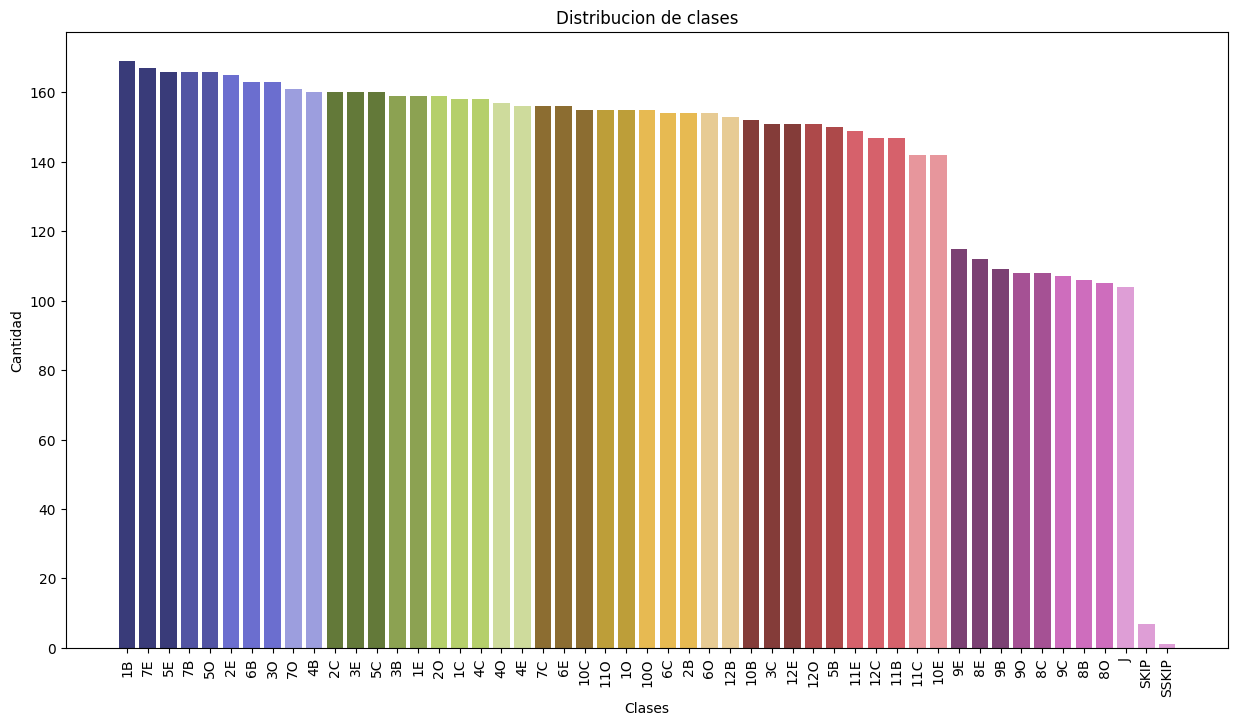

In [4]:
# Diccionario de nombres de clases
name_ids = {
    0: "1O", 1: "1C", 2: "1E", 3: "1B",
    4: "2O", 5: "2C", 6: "2E", 7: "2B",
    8: "3O", 9: "3C", 10: "3E", 11: "3B",
    12: "4O", 13: "4C", 14: "4E", 15: "4B",
    16: "5O", 17: "5C", 18: "5E", 19: "5B",
    20: "6O", 21: "6C", 22: "6E", 23: "6B",
    24: "7O", 25: "7C", 26: "7E", 27: "7B",
    28: "8O", 29: "8C", 30: "8E", 31: "8B",
    32: "9O", 33: "9C", 34: "9E", 35: "9B",
    36: "10O", 37: "10C", 38: "10E", 39: "10B",
    40: "11O", 41: "11C", 42: "11E", 43: "11B",
    44: "12O", 45: "12C", 46: "12E", 47: "12B",
    48: "J", 49: "SKIP", 50: "SSKIP"
}

def count_classes_in_folder(folder_path):
    class_counts = Counter()

    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'r') as file:
                for line in file:
                    class_id = int(line.split()[0])
                    class_counts[class_id] += 1

    return class_counts

def plot_class_distribution(class_counts, name_ids):
    # Ordenar las clases por la cantidad de ocurrencias de mayor a menor
    sorted_class_counts = class_counts.most_common()
    
    # Obtener nombres y conteos ordenados
    sorted_classes = [name_ids[class_id] for class_id, _ in sorted_class_counts]
    sorted_counts = [count for _, count in sorted_class_counts]

    # Crear una paleta de colores que se ajuste al número de clases
    cmap = plt.cm.get_cmap('tab20b', len(sorted_classes))
    colors = [cmap(i) for i in range(len(sorted_classes))]

    plt.figure(figsize=(15, 8))
    plt.bar(sorted_classes, sorted_counts, color=colors)
    plt.xlabel('Clases')
    plt.ylabel('Cantidad')
    plt.title('Distribucion de clases')
    plt.xticks(rotation=90)
    plt.show()

# Ruta a la carpeta que contiene los archivos .txt
folder_path = './fotos_textos_data'

# Contabilizar las clases
class_counts = count_classes_in_folder(folder_path)

# Graficar la distribución de clases
plot_class_distribution(class_counts, name_ids)